In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Create a mapping of original names to desired abbreviations
name_to_abbreviation = {
    'JFK INTERNATIONAL AIRPORT, NY US': 'nyc',
    'AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US': 'aus',
    'CHICAGO MIDWAY AIRPORT 3 SW, IL US': 'chi',
    'MIAMI OPA LOCKA AIRPORT, FL US': 'mia'
}

# Read CSV files
df1 = pd.read_csv('noaa_jfk_data.csv')
df2 = pd.read_csv('/Users/samdvorin/Desktop/code/542/weather-prediction/noaa_chi_aus_mia.csv')

# Concatenate DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Select core weather data and rename columns
core_weather = combined_df[["NAME", "DATE", "PRCP", "TMAX", "TMIN"]].copy()
core_weather.columns = ["name", "date", "precip", "temp_max", "temp_min"]

# Convert 'date' column to datetime and set as index
core_weather['date'] = pd.to_datetime(core_weather['date'])
# Filter data from the year 2020 onwards
core_weather = core_weather[core_weather['date'].dt.year >= 2010]
#core_weather.set_index('date', inplace=True)

# Drop rows with erroneous values (e.g., 9999)
core_weather.replace(9999, pd.NA, inplace=True)
core_weather.dropna(inplace=True)

# One-hot encode cities
core_weather = pd.get_dummies(core_weather, columns=["name"], prefix="", prefix_sep="")
core_weather.rename(columns=name_to_abbreviation, inplace=True)

# Process data and create target column
core_weather["target"] = core_weather.groupby("nyc")["temp_max"].shift(-1)
core_weather.dropna(inplace=True)
core_weather['year'] = core_weather['date'].dt.year - 1948
core_weather['month'] = core_weather['date'].dt.month
core_weather['day'] = core_weather['date'].dt.day
#core_weather.drop(columns=["date"], inplace=True)

# Splitting the DataFrame into four separate DataFrames for each city
df_nyc = core_weather[core_weather['nyc'] == 1].copy()
df_aus = core_weather[core_weather['aus'] == 1].copy()
df_chi = core_weather[core_weather['chi'] == 1].copy()
df_mia = core_weather[core_weather['mia'] == 1].copy()




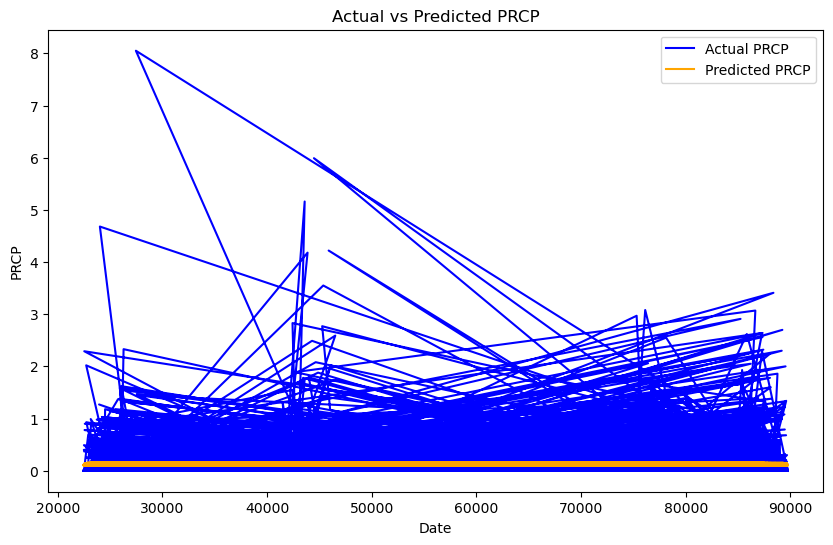

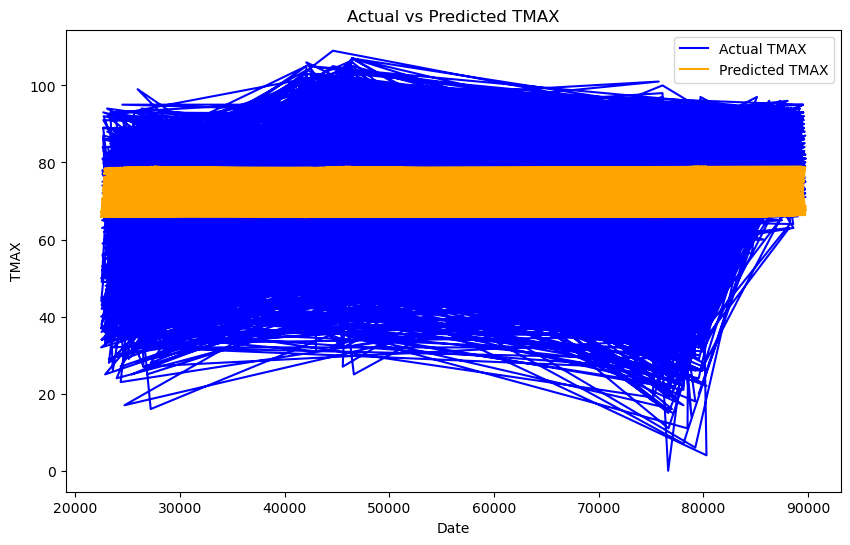

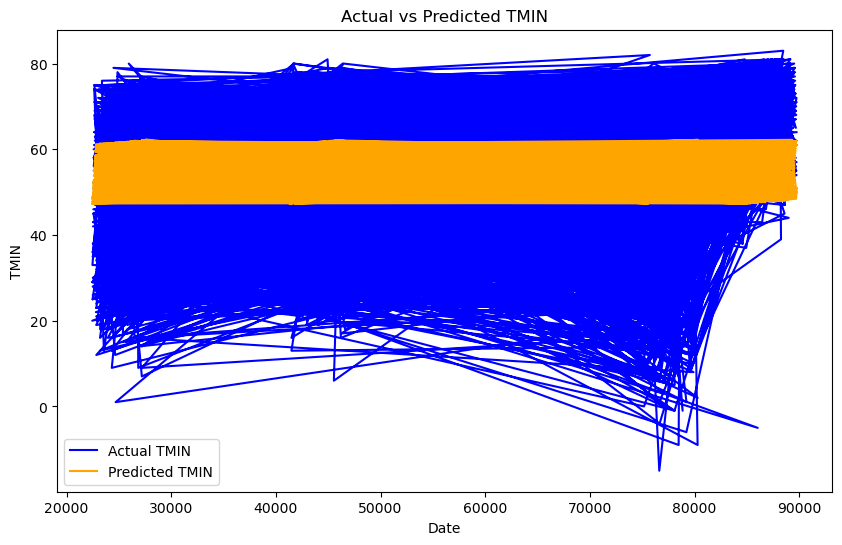

In [39]:
from sklearn.model_selection import GridSearchCV


# Define features and target variables
X = core_weather[['year', 'month', 'day']]
y = core_weather[['precip', 'temp_max', 'temp_min']]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying ridge regression
# Define the range of alpha values to search
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Create a parameter grid
param_grid = {'alpha': alphas}

# Initialize Ridge regression
ridge = Ridge()

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Train the Ridge regression model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)
y_pred_best = ridge_best.predict(X_test_scaled)

# Plotting actual versus predicted precipitation
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['precip'], label='Actual PRCP', color='blue')
plt.plot(y_test.index, y_pred[:, 0], label='Predicted PRCP', color='orange')
plt.title('Actual vs Predicted PRCP')
plt.xlabel('Date')
plt.ylabel('PRCP')
plt.legend()
plt.show()

# Plotting actual versus predicted maximum temperature
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['temp_max'], label='Actual TMAX', color='blue')
plt.plot(y_test.index, y_pred[:, 1], label='Predicted TMAX', color='orange')
plt.title('Actual vs Predicted TMAX')
plt.xlabel('Date')
plt.ylabel('TMAX')
plt.legend()
plt.show()

# Plotting actual versus predicted minimum temperature
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['temp_min'], label='Actual TMIN', color='blue')
plt.plot(y_test.index, y_pred[:, 2], label='Predicted TMIN', color='orange')
plt.title('Actual vs Predicted TMIN')
plt.xlabel('Date')
plt.ylabel('TMIN')
plt.legend()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [12]:
# Naive prediction
weather_naive = core_weather[['date', 'temp_max']].copy()
weather_naive['prev_temperature'] = weather_naive['temp_max'].shift(1)
weather_naive.dropna(inplace=True)  # Drop NaN values resulting from the shift
weather_naive['difference'] = weather_naive['temp_max'] - weather_naive['prev_temperature']
weather_naive['square_error'] = weather_naive['difference'] ** 2

# Calculate mean square error
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')


Square Error of the Naive Approach is 57.410


In [33]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# Select a subset of 5000 data points
weather_subset = core_weather.sample(n=5000, random_state=42)

##### one hot encoding ######
weather_LSTM = weather_subset.copy(deep=True)

##### setting tensor dimensions #####
input_data = weather_LSTM.drop(['date', 'temp_max'], axis=1)
targets = weather_LSTM['temp_max'].values
T = 20                    # Number of timesteps to look while predicting
D = input_data.shape[1]   # Dimensionality of the input
N = len(input_data) - T

##### separating data ##### 

# Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
    X_train[t, :, :] = input_data[t:t+T]
    y_train[t] = targets[t+T]

# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
    t = i + train_size
    X_test[i, :, :] = input_data[t:t+T]
    y_test[i] = targets[t+T]

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))


In [8]:
import time
##### simple LSTM #####

class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out


#### training function #####
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):



  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  ### CHANGE TO STOP ONCE PAST CERTAIN THRESHOLD
  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    start_time = time.time()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()
    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}, Time: {epoch_time:.2f} sec')

    #if (epoch + 1) % 50 == 0:
     # print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses



In [9]:
import matplotlib as plt

model = LSTM(D, 512, 2, 1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)



# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=100)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()



Epoch [1/100], Train Loss: 4762.809, Test Loss: 4376.535, Time: 10.84 sec
Epoch [2/100], Train Loss: 4525.137, Test Loss: 3651.670, Time: 10.46 sec
Epoch [3/100], Train Loss: 3784.830, Test Loss: 532.058, Time: 10.84 sec
Epoch [4/100], Train Loss: 543.667, Test Loss: 16106.316, Time: 10.62 sec
Epoch [5/100], Train Loss: 15776.583, Test Loss: 34745.203, Time: 10.55 sec
Epoch [6/100], Train Loss: 35206.328, Test Loss: 1155.930, Time: 10.96 sec
Epoch [7/100], Train Loss: 1212.298, Test Loss: 6194.342, Time: 10.96 sec
Epoch [8/100], Train Loss: 5989.906, Test Loss: 4478.996, Time: 10.36 sec
Epoch [9/100], Train Loss: 4306.026, Test Loss: 689.602, Time: 10.91 sec
Epoch [10/100], Train Loss: 639.103, Test Loss: 1980.096, Time: 11.16 sec
Epoch [11/100], Train Loss: 2068.552, Test Loss: 3356.819, Time: 11.41 sec
Epoch [12/100], Train Loss: 3483.017, Test Loss: 1006.196, Time: 10.62 sec
Epoch [13/100], Train Loss: 1055.014, Test Loss: 1000.469, Time: 10.38 sec
Epoch [14/100], Train Loss: 929.56

AttributeError: module 'matplotlib' has no attribute 'plot'

Mean square error is: 454.977


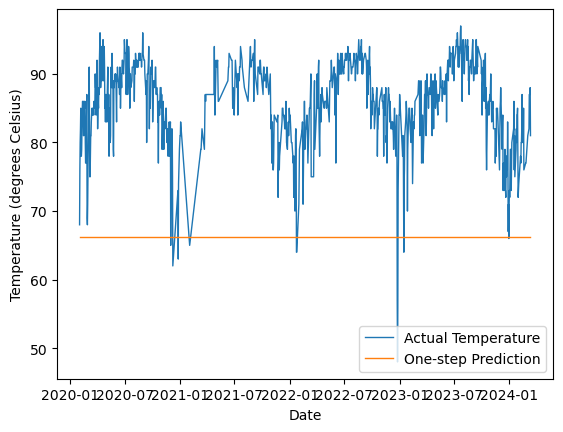

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
    input_ = X_test[i].reshape(1, T, D)
    p = model(input_)[0, 0].item()

    # update the predictions list
    test_predictions.append(p)

plot_len = len(test_predictions)
plot_df = core_weather[['date', 'temp_max']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('date', inplace=True)

plt.plot(plot_df['temp_max'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Temperature (degrees Celsius)')
plt.legend(loc='lower right')

LTSM_error = pd.DataFrame(test_target, columns=['targets'])
LTSM_error['predictions'] = test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')
